In [81]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import glob
import re
from datetime import datetime

In [82]:
# todo: transform into a sqlalchemy method which dumps the data into a table

def get_json_files(strategy_name):
    # Define the directory path for the strategy
    strategy_dir = os.path.join('../strategy', strategy_name, 'backtests')
    # todo: replace for strategy in production
    # strategy_dir = os.path.join('/strategy', strategy_name, 'backtests')
    
    # Get all directories under the strategy directory
    dirs = [d for d in os.listdir(strategy_dir) if os.path.isdir(os.path.join(strategy_dir, d))]
    # Sort the directories by date
    dirs.sort(key=lambda x: datetime.strptime(x, '%Y-%m-%d_%H-%M-%S'), reverse=True)
    # Get the newest directory
    newest_dir = dirs[0]
    # Use glob to find the JSON file that matches the pattern in the newest directory
    json_files = glob.glob(os.path.join(strategy_dir, newest_dir, '*.json'))
    # Define the pattern for the JSON file
    pattern = re.compile(r'\d{10}\.json$')
    # Filter the json_files list to only include files that match the pattern
    json_files = [f for f in json_files if pattern.match(os.path.basename(f))]
    # Since we know there's only one file that matches the pattern, we can just return the first item in the list
    return json_files[0]

In [83]:
file_dir = get_json_files('ib_loader_plus')

In [84]:
# todo: transform into a sqlalchemy method which dumps the data into a table

# testing
def print_first_nodes(json_file):
    # Open and load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Print the first level keys (nodes) of the JSON object
    for key in data.keys():
        if key == 'Statistics':
            print('=== Statistics ===')
            for sub_key in data[key].items():
                print(sub_key)
                # print(f'{sub_key[0]}: {sub_key[1]}')
        elif key == 'RuntimeStatistics':
            print('=== Runtime Statistics ===')
            for sub_key in data[key].items():
                print(sub_key)
            
# Use the function
print_first_nodes(file_dir)

=== Statistics ===
('Total Trades', '93')
('Average Win', '1.97%')
('Average Loss', '-2.27%')
('Compounding Annual Return', '-14.844%')
('Drawdown', '20.300%')
('Expectancy', '-0.106')
('Net Profit', '-13.673%')
('Sharpe Ratio', '-0.869')
('Sortino Ratio', '-0.96')
('Probabilistic Sharpe Ratio', '3.314%')
('Loss Rate', '52%')
('Win Rate', '48%')
('Profit-Loss Ratio', '0.87')
('Alpha', '-0.106')
('Beta', '0.941')
('Annual Standard Deviation', '0.166')
('Annual Variance', '0.028')
('Information Ratio', '-0.722')
('Tracking Error', '0.143')
('Treynor Ratio', '-0.154')
('Total Fees', '$68799.45')
('Estimated Strategy Capacity', '$0')
('Lowest Capacity Asset', 'BHP.IBData 2S')
('Portfolio Turnover', '27.79%')
=== Runtime Statistics ===
('Equity', '$863,265.14')
('Fees', '-$68,799.45')
('Holdings', '$861,041.10')
('Net Profit', '$-119,811.59')
('Probabilistic Sharpe Ratio', '3.314%')
('Return', '-13.67 %')
('Unrealized', '$-17,612.10')
('Volume', '$85,999,318.25')


# potential plots

The following information will useful for plots, as well as for keeping in a database table:

1. ProfitLoss: each element in it has sub elements, where the key is the order number and the useful values are:
    - key is in the format: "2023-01-13T14:59:00Z"
    - value is a float (numeric).
    
2. Orders (it would be cool to include as a point in the plot):
    - Symbol: the symbol of the asset
    - Time: the time at which the order was executed
    - Price: the price at which the order was executed
    - Quantity: the number of shares in the order
    - Value: the total value of the order (price * quantity)
3. Charts
    - This is a bit trickier, but can be done by accessing the data here. Below is an example of how to access the data for the "Strategy Equity" chart:




In [85]:
def calculate_cumulative_returns(json_file):
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract the equity curve data and benchmark curve data
    equity_curve = data['Charts']['Strategy Equity']['Series']['Equity']['Values']
    # make a sublist
    equity_curve = [[sublist[0], sublist[1]] for sublist in equity_curve]
    
    # # Create a DataFrame for the equity curve data
    equity_df = pd.DataFrame(equity_curve, columns=['Date', 'Equity'])
    equity_df['Date'] = pd.to_datetime(equity_df['Date'], unit='s')
    
    
    # Extract Benchmark Curve data
    benchmark_curve = data['Charts']['Benchmark']['Series']['Benchmark']['Values']
    
    # Other elements in Charts, this will return x and y values (y values are in percent)
    equity_drawdown = data['Charts']['Drawdown']['Series']['Equity Drawdown']['Values']
    
    
    # Create a DataFrame for the benchmark curve data
    benchmark_df = pd.DataFrame(benchmark_curve)
    benchmark_df['Date'] = pd.to_datetime(benchmark_df['x'], unit='s')
    benchmark_df.rename(columns={'y': 'Benchmark'}, inplace=True)
    benchmark_df.drop(columns='x', inplace=True)

    # Merge the two DataFrames on the 'Date' column
    df = pd.merge(equity_df, benchmark_df, on='Date')

    # Calculate the cumulative returns for the 'Equity' and 'Benchmark' columns
    df['EquityCumulativeReturn'] = df['Equity'].pct_change().cumsum()
    df['BenchmarkCumulativeReturn'] = df['Benchmark'].pct_change().cumsum()

    return df
    # return equity_curve

In [86]:
df = calculate_cumulative_returns(file_dir)

In [88]:
df.head()

,Date,Equity,Benchmark,EquityCumulativeReturn,BenchmarkCumulativeReturn
0,2023-01-01 05:00:00,1000000.0,63.51,NaN,NaN
1,2023-01-02 05:00:00,1000000.0,63.51,0.0,0.000000
2,2023-01-03 05:00:00,1000000.0,63.51,0.0,0.000000
3,2023-01-04 05:00:00,1000000.0,62.67,0.0,-0.013226
4,2023-01-05 05:00:00,1000000.0,63.62,0.0,0.001933


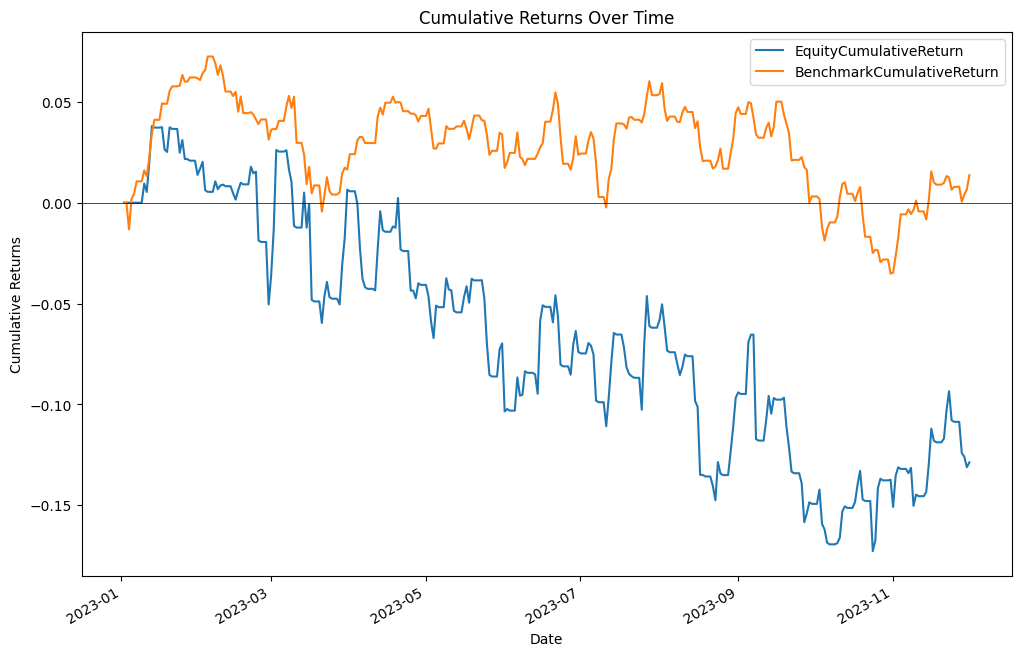

In [89]:
# Set 'Date' as the index for the plot
df.set_index('Date', inplace=True)

# Plot 'EquityCumulativeReturn' and 'BenchmarkCumulativeReturn'
df[['EquityCumulativeReturn', 'BenchmarkCumulativeReturn']].plot(figsize=(12,8))

# Set the title and labels
plt.title('Cumulative Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
# Add x-axis at y=0
plt.axhline(0, color='black', linewidth=0.5)

# Display the plot
plt.show()

In [90]:
def calculate_cumulative_returns(json_file):
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Extract the equity curve data and benchmark curve data
    equity_curve = data['Charts']
    
    for key,value in equity_curve.items():
        print(each)
    

In [91]:
calculate_cumulative_returns(file_dir)

Drawdown
Benchmark
Assets Sales Volume
Portfolio Turnover
Strategy Equity
Capacity
Exposure
